In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
import sys
sys.path.extend(['..', '../..'])
from postgis.psycopg import register
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import box
from db_importer.settings import *
import scipy.stats

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [54]:
#files= ['sim_data/b1_default.csv', 'sim_data/b1_default_ped.csv', 'sim_data/b1_new_params.csv', 'sim_data/b1_new_params_ped.csv']
files = ['sim_data/oranienstr_new_params_all.csv', 'sim_data/oranienstr_new_params_slow.csv', 'sim_data/oranienstr_new_params_medium.csv', 'sim_data/oranienstr_new_params_fast.csv', 'sim_data/oranienstr_default.csv',]


def calc_a_min(group):
    a = (group['vehicle_speed'] - group.shift(1)['vehicle_speed']) / 1 #timestep_time is always 1
    return a.min()

def calc_a_max(group):
    a = (group['vehicle_speed'] - group.shift(1)['vehicle_speed']) / 1 #timestep_time is always 1
    return a.max()

max_accs_arr = []
max_decs_arr = []
max_velos_arr = []

for file in files:
    df = pd.read_csv(file, delimiter=';')
    df = df[df.vehicle_id.str.startswith('flow', na=False)]
    grouped = df.groupby('vehicle_id')
    
    max_accs_arr.append(grouped.apply(calc_a_max).values)
    max_decs_arr.append(grouped.apply(calc_a_min).values)
    
    max_velos = []
    
    for key, item in grouped:
        max_velos.append(max(grouped.get_group(key)['vehicle_speed']))
        
    max_velos_arr.append(max_velos)

In [ ]:
##oranien
with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       ST_AsGeoJSON(geom) :: json -> 'coordinates' AS coordinates,
       timestamps,
       velos,
       durations,
       distances
FROM ride
WHERE st_intersects(geom,
                    st_setsrid( st_makebox2d( st_makepoint(13.4112,52.5031), st_makepoint(13.4117,52.5039)), 4326))
                AND st_intersects(geom,
                    st_setsrid( st_makebox2d( st_makepoint(13.426,52.4991), st_makepoint(13.4264,52.4998)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamp', 'velo', 'duration', 'dist'])

In [ ]:
print(df)
print(df['velo'].max() > np.zeros(len(df['velo'].max())))
print(len(df.velo.max()))
print(df['velo'].max())

v = df.velo.apply(lambda x: np.median(-np.sort(-np.array(x))[:10])).values

v = v[v != 0]

v

In [ ]:


def find_closest_index(df, dt_obj):
    return np.argmin(np.abs(df['timestamp'] - dt_obj))


def process_acceleration_segments(df):
    df = pd.DataFrame(list(zip(df.timestamp, df.velo, df.duration, df.dist)), columns = ['timestamp', 'velo', 'duration', 'dist'])
    
    
    tmp = df.copy()
    
    df['velo'] = tmp['velo']
    df['a'] = (df['velo'] - df.shift(1)['velo']) / df['duration']

    tmp = insert_empty_rows(df).copy()
    tmp_ak = tmp[['timestamp', 'a']].copy()

    ## es werden empty rows reingebuffert, damit die Auflösung von a erhöht werden kann (über interpolate).
    ## So lassen sich values nahe 0 finden. Bei 1/3Hz Auflösung gelänge das bei zu wenigen.
    t0 = tmp_ak['timestamp'].min()
    m = tmp_ak['timestamp'].notnull()
    tmp_ak.loc[m, 't_int'] = (tmp_ak.loc[m, 'timestamp'] - t0).dt.total_seconds()
    tmp_ak['timestamp'] = t0 + pd.to_timedelta(tmp_ak.t_int.interpolate(), unit='s')

    tmp_ak = tmp_ak[~tmp_ak.timestamp.isnull()]
    tmp_ak['a'] = tmp_ak['a'].astype('float64').interpolate()

    th = 0.005
    extrema = tmp_ak[tmp_ak['a'].between(-th, th)].timestamp.values

    # df = df.set_index('timestamp')
    segments = []
    for i in range(len(extrema)):
        if i + 1 == len(extrema):
            break
        e1 = extrema[i]
        e2 = extrema[i + 1]
        segments.append(df[find_closest_index(df, e1):find_closest_index(df, e2)])

    df_s = []
    for s in segments:
        #s = s[s['velo'].notna()]
        if len(s) < 1:
            continue
        if (s.dist.sum() < 20) | (s.dist.sum() > 350):
            continue
        if (s.duration.sum() < 5) | (s.duration.sum() > 60):
            continue

        initial_speed = s['velo'].iloc[0]
        final_speed = s['velo'].iloc[-1]
        if final_speed == initial_speed:
            continue
        t = abs(initial_speed - final_speed) / max(initial_speed, final_speed)
        if t < 0.5:
            continue
        if final_speed > initial_speed:
            ## hier < x, da es vorkommen kann, dass an den Grenzen des Segments marginal negative values vorkommen.
            if (s['a'] < -0.1).any():
                continue
            s['type'] = 'a'
        else:
            if (s['a'] > 0.1).any():
                continue
            s['type'] = 'd'
        global seg_id
        s['seg_id'] = seg_id
        seg_id += 1
        df_s.append(s)
        return pd.concat(df_s).to_numpy()

def insert_empty_rows(df): 
    data = df.values
    for i in range(4):
        nans = np.where(np.empty_like(data), np.nan, np.nan)
        data = np.hstack([nans, data])
    return pd.DataFrame(data.reshape(-1, df.shape[1]), columns=df.columns)

seg_id = 0

df_series = pd.DataFrame()
df_series = df.apply(lambda x: process_acceleration_segments(x[['timestamp', 'velo', 'duration', 'dist']]), axis=1)


In [ ]:
res = pd.DataFrame(columns=['timestamp', 'velo', 'duration', 'dist', 'a', 'type', 'seg_id'])
for i in df_series:
    res = pd.concat([res, pd.DataFrame(i, columns=['timestamp', 'velo', 'duration', 'dist', 'a', 'type', 'seg_id'])])
res

In [ ]:
a_simra= res[res['type'] == 'a'].groupby('seg_id').a.max().dropna()
a_simra

In [ ]:
a_simra = a_simra[(a_simra[:] > 0.2)]

In [55]:
##oranien
with DatabaseConnection() as cur:
    group_q = lambda perc: f"""SELECT percentile_cont({perc}) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 GROUP BY filename) as one"""
    cur.execute(f"""
            SELECT two.filename, two.max_v, one.accel, one.decel, CASE WHEN two.avg_v < ({group_q(0.25)}) THEN 0 ELSE CASE WHEN two.avg_v < ({group_q(0.75)}) THEN 1 ELSE 2 END END as group FROM (
                SELECT filename, MAX(accel) as accel, MIN(accel) as decel FROM accels GROUP BY filename
            ) as one JOIN (
                SELECT filename, SUM(velo * duration)/SUM(duration) as avg_v, MAX(velo) as max_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' and velo < 15 GROUP BY filename
            ) as two ON (one.filename = two.filename) JOIN ride as r ON (one.filename = r.filename)
            WHERE st_intersects(r.geom,
                    st_setsrid( st_makebox2d( st_makepoint(13.4112,52.5031), st_makepoint(13.4117,52.5039)), 4326))
                AND st_intersects(r.geom,
                    st_setsrid( st_makebox2d( st_makepoint(13.426,52.4991), st_makepoint(13.4264,52.4998)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'max_v', 'max_accel', 'max_decel', 'group'])

OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.


In [ ]:
a_simra = df.query('max_accel >= 0.3')[['max_accel']]
a_simra_slow = df.query('group == 0 and max_accel >= 0.3')[['max_accel']]
a_simra_medium = df.query('group == 1 and max_accel >= 0.3')[['max_accel']]
a_simra_fast = df.query('group == 2 and max_accel >= 0.3')[['max_accel']]
print(a_simra_slow.info())
print(a_simra_medium.info())
print(a_simra_fast.info())


In [34]:
v = df[['max_v']]
v_slow = df.query('group == 0')[['max_v']]
v_medium = df.query('group == 1')[['max_v']]
v_fast = df.query('group == 2')[['max_v']]

In [39]:
d_simra = df.query('max_decel < -0.1')[['max_decel']]
d_simra_slow = df.query('group == 0 and max_decel < -0.1')[['max_decel']]
d_simra_medium = df.query('group == 1 and max_decel < -0.1')[['max_decel']]
d_simra_fast = df.query('group == 2 and max_decel < -0.1')[['max_decel']]

In [18]:
# plotting config
columnwidth = 3.5
textwidth = 3.5 * 2 + 0.25
figsize = (columnwidth * 0.97, 1.75)
params = {
     "pdf.fonttype": 42,
     "font.family": "serif",
     "font.serif": "Linux Libertine",
     "font.sans-serif": [],
     "font.monospace": [],
     # Make the legend/label fonts a little smaller
     "font.size": 8,
     "axes.labelsize": 8,
     "axes.titlesize": 8,
     "legend.fontsize": 6,
     "legend.title_fontsize": 8,
     "xtick.labelsize": 7,
     "ytick.labelsize": 7,
     "figure.figsize": figsize,
     "figure.autolayout": True,
     # save some space around figures when saving
     "savefig.bbox": "tight",
     "savefig.pad_inches": 0.025,
}
pdf_params = {
     "text.usetex": True,
     "pgf.texsystem": "pdflatex",
     "pgf.rcfonts": False,
     "pgf.preamble": "\n".join(
         [
             # put LaTeX preamble declarations here
             r"\usepackage[utf8x]{inputenc}",
             r"\usepackage[T1]{fontenc}",
         ]
     ),
}
# for PFG plotting:
params.update(**pdf_params)
plt.rcParams.update(params)

In [ ]:
colors = ['r', u'#ff7f0e', u'#1f77b4']

plt.subplots(figsize = (10, 5))

plt.hist([max_accs_arr[4], max_accs_arr[0], a_simra.values.flatten()], bins=15,rwidth=1,  label=['SUMO default', 'Our approach (All)', 'SimRa (All)'], color = colors, density=True)
plt.ylim(0,6)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_oranien_acc_all.pdf', bbox_inches='tight')
plt.show()

In [ ]:
colors = ['r', u'#ff7f0e', u'#1f77b4']

plt.subplots(figsize = (10, 5))

plt.hist([max_accs_arr[4], max_accs_arr[1], a_simra_slow.values.flatten()], bins=15,rwidth=1,  label=['SUMO default', 'Our approach (Slow)', 'SimRa (Slow)'], color = colors, density=True)
plt.ylim(0,6)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_oranien_acc_slow.pdf', bbox_inches='tight')
plt.show()

In [ ]:
colors = ['r', u'#ff7f0e', u'#1f77b4']

plt.subplots(figsize = (10, 5))

plt.hist([max_accs_arr[4], max_accs_arr[2], a_simra_medium.values.flatten()], bins=15,rwidth=1,  label=['SUMO default', 'Our approach (Medium)', 'SimRa (Medium)'], color = colors, density=True)
plt.ylim(0,6)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_oranien_acc_medium.pdf', bbox_inches='tight')
plt.show()

In [ ]:
colors = ['r', u'#ff7f0e', u'#1f77b4']

plt.subplots(figsize = (10, 5))

plt.hist([max_accs_arr[4], max_accs_arr[3], a_simra_fast.values.flatten()], bins=15,rwidth=1,  label=['SUMO default', 'Our approach (Fast)', 'SimRa (Fast)'], color = colors, density=True)
plt.ylim(0,6)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_oranien_acc_fast.pdf', bbox_inches='tight')
plt.show()

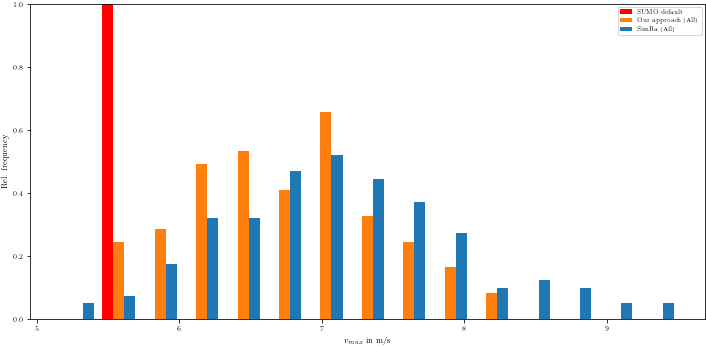

In [42]:
plt.subplots(figsize = (10, 5))

plt.hist([max_velos_arr[4], max_velos_arr[0], v.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (All)', 'SimRa (All)'],  color = colors, density=True)
plt.legend()
plt.ylim(0,1)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$v_{max}$ in m/s')
plt.savefig('images/sim_oranien_velo_all.pdf', bbox_inches='tight')
plt.show()


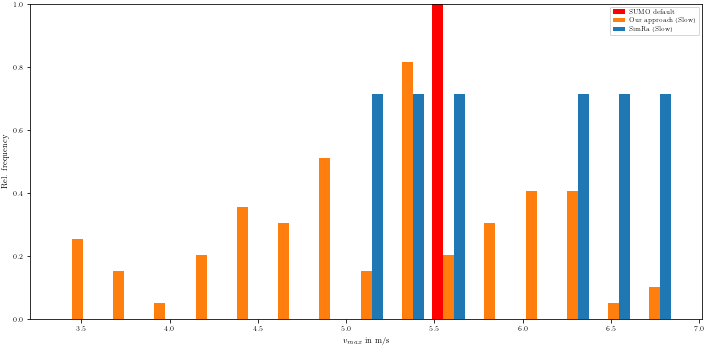

In [43]:
plt.subplots(figsize = (10, 5))

plt.hist([max_velos_arr[4], max_velos_arr[1], v_slow.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (Slow)', 'SimRa (Slow)'],  color = colors, density=True)
plt.legend()
plt.ylim(0,1)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$v_{max}$ in m/s')
plt.savefig('images/sim_oranien_velo_slow.pdf', bbox_inches='tight')
plt.show()


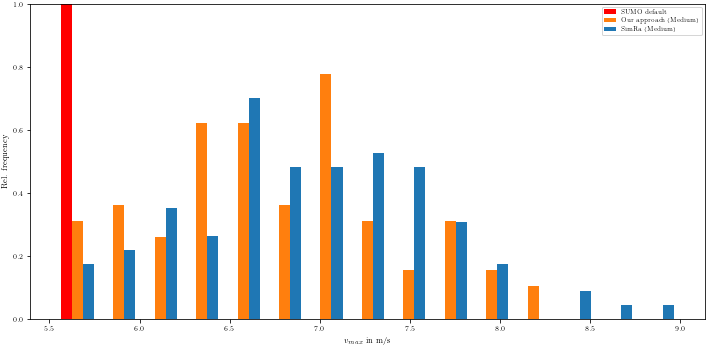

In [44]:
plt.subplots(figsize = (10, 5))

plt.hist([max_velos_arr[4], max_velos_arr[2], v_medium.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (Medium)', 'SimRa (Medium)'],  color = colors, density=True)
plt.legend()
plt.ylim(0,1)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$v_{max}$ in m/s')
plt.savefig('images/sim_oranien_velo_medium.pdf', bbox_inches='tight')
plt.show()


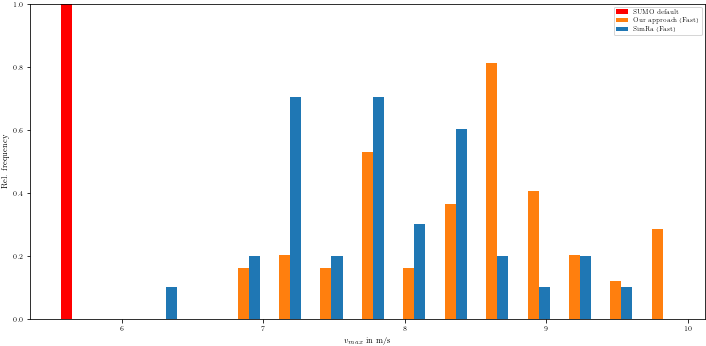

In [45]:
plt.subplots(figsize = (10, 5))

plt.hist([max_velos_arr[4], max_velos_arr[3], v_fast.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (Fast)', 'SimRa (Fast)'],  color = colors, density=True)
plt.legend()
plt.ylim(0,1)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$v_{max}$ in m/s')
plt.savefig('images/sim_oranien_velo_fast.pdf', bbox_inches='tight')
plt.show()


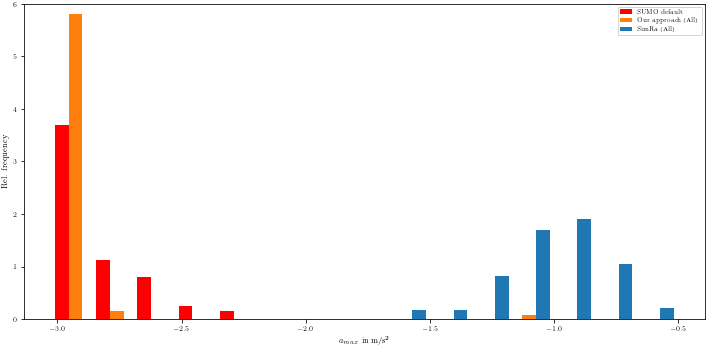

In [52]:
colors = ['r', u'#ff7f0e', u'#1f77b4']

plt.subplots(figsize = (10, 5))

plt.hist([max_decs_arr[4], max_decs_arr[0], d_simra.values.flatten()], bins=15,rwidth=1,  label=['SUMO default', 'Our approach (All)', 'SimRa (All)'], color = colors, density=True)
plt.ylim(0,6)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_oranien_dec_all.pdf', bbox_inches='tight')
plt.show()

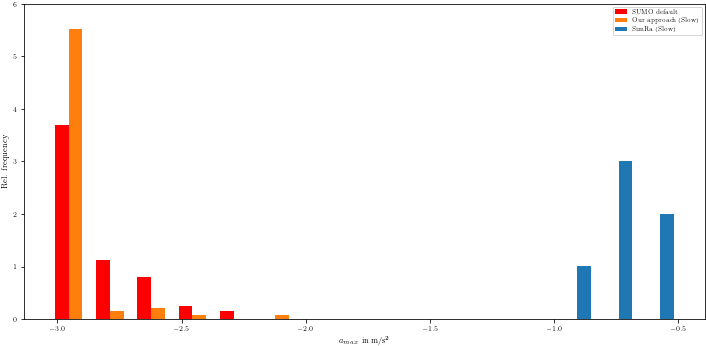

In [56]:
colors = ['r', u'#ff7f0e', u'#1f77b4']

plt.subplots(figsize = (10, 5))

plt.hist([max_decs_arr[4], max_decs_arr[1], d_simra_slow.values.flatten()], bins=15,rwidth=1,  label=['SUMO default', 'Our approach (Slow)', 'SimRa (Slow)'], color = colors, density=True)
plt.ylim(0,6)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_oranien_dec_slow.pdf', bbox_inches='tight')
plt.show()

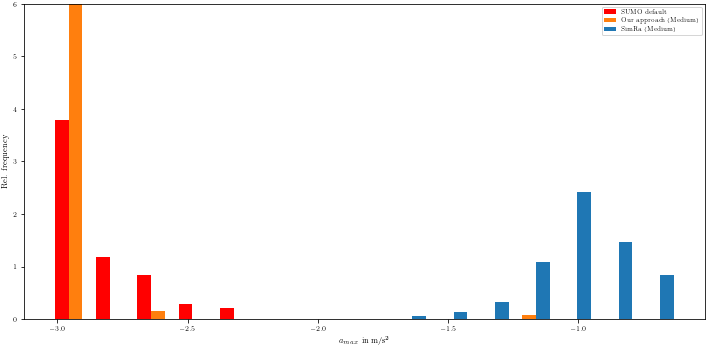

In [57]:
colors = ['r', u'#ff7f0e', u'#1f77b4']

plt.subplots(figsize = (10, 5))

plt.hist([max_decs_arr[4], max_decs_arr[2], d_simra_medium.values.flatten()], bins=15,rwidth=1,  label=['SUMO default', 'Our approach (Medium)', 'SimRa (Medium)'], color = colors, density=True)
plt.ylim(0,6)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_oranien_dec_medium.pdf', bbox_inches='tight')
plt.show()

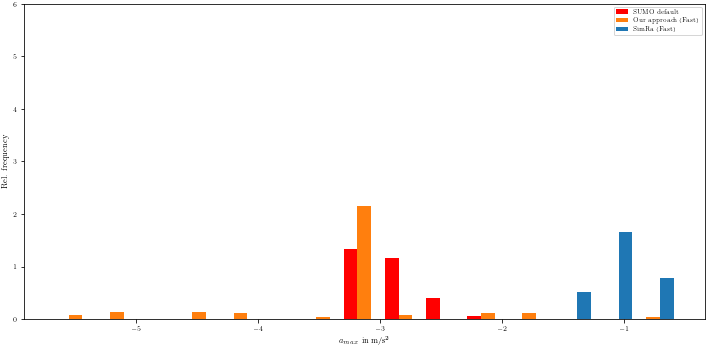

In [58]:
colors = ['r', u'#ff7f0e', u'#1f77b4']

plt.subplots(figsize = (10, 5))

plt.hist([max_decs_arr[4], max_decs_arr[3], d_simra_fast.values.flatten()], bins=15,rwidth=1,  label=['SUMO default', 'Our approach (Fast)', 'SimRa (Fast)'], color = colors, density=True)
plt.ylim(0,6)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_oranien_dec_fast.pdf', bbox_inches='tight')
plt.show()